<a href="https://colab.research.google.com/github/PremGorecki/MachineLearning/blob/main/01_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd


In [2]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()




dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [3]:
X, y = mnist["data"], mnist["target"]
X.shape


(70000, 784)

In [4]:
y.shape

(70000,)

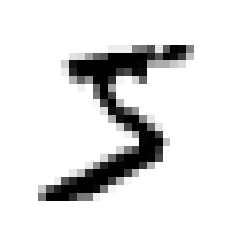

In [5]:
#Jak wygląda jedna cyfra

import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X.iloc[0]

import numpy as np
some_digit = np.array(some_digit)

some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap = "binary")
plt.axis("off")
plt.show()



In [6]:
y[0]

'5'

In [7]:
# y jest stringiem dlatego zróbmy z niego liczby

y = y.astype(np.uint8)

In [8]:
y[0]

5

In [9]:
# podział na zbiór treningowy i testowy
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [10]:
# Na razie rozpoznajemy tylko 5kią ..czyli klasyfikator binarny

y_train_5 = (y_train == 5) # Wartość True dla piątek, False dla wszystkich pozostałych cyfr
y_test_5 = (y_test == 5)

In [11]:
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [12]:
sgd_clf.predict([some_digit])

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  "X does not have valid feature names, but"


array([ True])

### Miary wydajności

In [13]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")


array([0.95035, 0.96035, 0.9604 ])

In [14]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [15]:
#Macierz pomyłek
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)


array([[53892,   687],
       [ 1891,  3530]])

In [16]:
# precyzja i pełność
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_5, y_train_pred) # == 4096 / (4096 + 1522)


0.8370879772350012

In [17]:
recall_score(y_train_5, y_train_pred) # == 4096 / (4096 + 1325

0.6511713705958311

In [18]:
#F1 score
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7325171197343846

In [19]:
#Kompromis miedzy precyzcją a pełnością

y_scores = sgd_clf.decision_function([some_digit])
y_scores


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  "X does not have valid feature names, but"


array([2164.22030239])

In [20]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [21]:
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

In [22]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
method="decision_function")

In [23]:
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

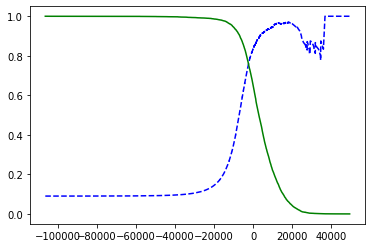

In [24]:
import matplotlib.pyplot as plt

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
  plt.plot(thresholds, precisions[:-1], "b--", label="Precyzja")
  plt.plot(thresholds, recalls[:-1], "g-", label="Pełność")

# Zaznaczenie progu, dodanie legendy, etykiet osi i siatki
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

In [25]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)] 
threshold_90_precision

3370.019499143958

In [26]:
y_train_pred_90 = (y_scores > threshold_90_precision)

In [27]:
precision_score(y_train_5, y_train_pred_90)

0.9

In [28]:
recall_score(y_train_5, y_train_pred_90)

0.47980077476480354

In [29]:
# Wykres krzywej ROC
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

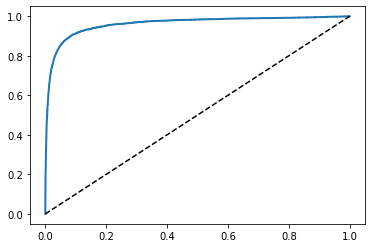

In [30]:
def plot_roc_curve(fpr, tpr, label=None):
  plt.plot(fpr, tpr, linewidth=2, label=label)
  plt.plot([0, 1], [0, 1], 'k--') # Przerywana przekątna wykresu
# Dodanie etykiety osi i siatki
plot_roc_curve(fpr, tpr)
plt.show()

In [31]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

In [32]:
# Teraz sprawdzamy na innym klasyfikatorze
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
method="predict_proba")

In [33]:
y_scores_forest = y_probas_forest[:, 1] # Wynik = prawd. przynależności do klasy pozytywnej
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)

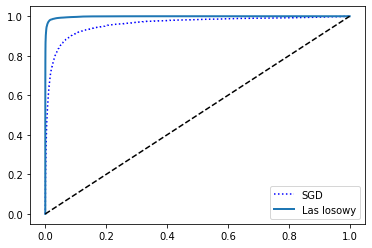

In [34]:
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Las losowy")
plt.legend(loc="lower right")
plt.show()

In [35]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

### Wieloklasowa

In [36]:
#Klasyfikator wektorów nośnych

from sklearn.svm import SVC
svm_clf = SVC()
svm_clf.fit(X_train, y_train) # y_train, a nie y_train_5
svm_clf.predict([some_digit])


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  "X does not have valid feature names, but"


array([5], dtype=uint8)

In [37]:
"""
Scikit-Learn skorzystał w rzeczywistości ze strategii OvO: wytrenował
45 klasyfikatorów binarnych, uzyskał wyniki decyzyjne dla analizowanego obrazu i wybrał klasę, która
wygrała większość „pojedynków”.
"""
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  "X does not have valid feature names, but"


array([[ 1.72501977,  2.72809088,  7.2510018 ,  8.3076379 , -0.31087254,
         9.3132482 ,  1.70975103,  2.76765202,  6.23049537,  4.84771048]])

In [38]:
# Można samemu wybrać strategię

from sklearn.multiclass import OneVsRestClassifier
ovr_clf = OneVsRestClassifier(SVC())
ovr_clf.fit(X_train, y_train)
ovr_clf.predict([some_digit])


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packa

array([5], dtype=uint8)

In [39]:
len(ovr_clf.estimators_)

10

In [40]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  "X does not have valid feature names, but"


array([3], dtype=uint8)

In [41]:
sgd_clf.decision_function([some_digit])

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  "X does not have valid feature names, but"


array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

In [ ]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

### Analiza błędów

In [ ]:
# Macierz pomyłek

y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx  

In [ ]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

In [ ]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

In [ ]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

In [ ]:
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]
plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.show()

### Klasyfikacja wieloetykietowa

In [10]:
from sklearn.neighbors import KNeighborsClassifier
y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

In [11]:
knn_clf.predict([some_digit])

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  "X does not have valid feature names, but"


array([[False,  True]])

In [20]:
#F1 score
from sklearn.model_selection import cross_val_predict
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)



In [21]:
from sklearn.metrics import f1_score
f1_score(y_multilabel, y_train_knn_pred, average="macro")

0.976410265560605

### Klasyfikacja wielowyjściowa

In [22]:
# Utworzenie zbiorów uczących i testowych

noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

In [ ]:
knn_clf.fit(X_train_mod, y_train_mod)
some_index = 5
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)